In [ ]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


# **0 - Install Required Libraries**



In [ ]:
!pip3 install -q -U keras-tuner==1.1.3
!pip3 install tensorflow-addons[tensorflow]
!pip3 install pickle5
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip install livelossplot
!pip install -q tensorflow==2.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 805.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pickle5: filename=pickle5-0.0.11-cp310-cp310-linux_x86_64.whl size=255314 sha256=45f82932b7c813982da62aeaba1aecf16ec44058d23a36d28902003d805c9c47
  Stored in directory: /root/.cache/pip/wheels/7d/14/ef/4aab19d27fa8e58772be5c71c16add0426acf9e1f64353235c
Successfully built pickle5
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Version '8.1.0.77-1+cuda11.2' for 'libcudnn8' was n

# **1- Import Required Libraries**

In [ ]:
import os

init_seed = 1640

os.environ['PYTHONHASHSEED'] = str(init_seed)

# For working on GPUs from "TensorFlow Determinism"
# Had to set all batch norms' fuse parameter to False
# because of a runtime error saying that deterministic
# version of batch_norm is not defined
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(init_seed)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(init_seed)

#  Below does not help with using batch norm, so will keep it commented because
#  mode is reproducible without it.
tf.config.experimental.enable_op_determinism()


from keras import backend as K

# # The below set_seed() will make random number generation
# # in the TensorFlow backend have a well-defined initial state.
# # For further details, see:
# # https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(init_seed)


In [ ]:
import re
import sys
import json
import math
import warnings
import pprint
from collections import defaultdict
from collections import Counter
from itertools import chain

import cv2
from PIL import Image, ImageOps
import pickle5 as pickle

In [ ]:
import pandas as pd


import matplotlib
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from livelossplot import PlotLossesKeras

import keras_tuner as kt
# import tensorflow_addons as tfa
from tensorflow import keras
from keras.losses import Loss
from keras.layers import Concatenate
from keras.utils.layer_utils import count_params
from keras.metrics import categorical_accuracy, AUC
from sklearn.metrics import (accuracy_score, f1_score,
                             precision_score, recall_score,
                             classification_report,
                             confusion_matrix
                            )

# **3 - Connect to Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sys.path.append('/content/drive/MyDrive/joint_level_generation_translation/')

In [ ]:
%cd "drive/MyDrive/joint_level_generation_translation/"

/content/drive/MyDrive/joint_level_generation_translation


# **4 - Load Configs and Datasets**

In [ ]:
# TEST_GAME = "kid_icarus" #@param
CHANNELS = 3 #@param
IMG_WIDTH = 75 #@param
IMG_HEIGHT = 50 #@param
# SINGLE_GAME = "kid_icarus" #@param
TUNE_FIRST = False


In [ ]:
from src.config.config_loader import load_config
config = load_config("src/config/config.yaml")

# retrieve list of games from config
# game_keys = list(config["datasets"].keys())
game_keys = ["kid_icarus", "smb"]

In [ ]:
all_datasets = {}

for game_key in game_keys:
    data = dict()
    print(f"Loading {game_key}...")
    with open(f"./data/{game_key}/dataset.pickle", "rb") as fh:
        data = pickle.load(fh)
        all_datasets[game_key] = data

Loading kid_icarus...
Loading smb...


# **5 - Data Analysis**

{1: '#', 2: '-', 3: 'D', 4: 'H', 5: 'M', 6: 'T', 7: 'B', 8: 'S', 9: 'O'}
kid_icarus
smb
1 88926
2 407553
6 12458
3 5745
4 4306
5 6794
8 5613
9 1532
7 1073


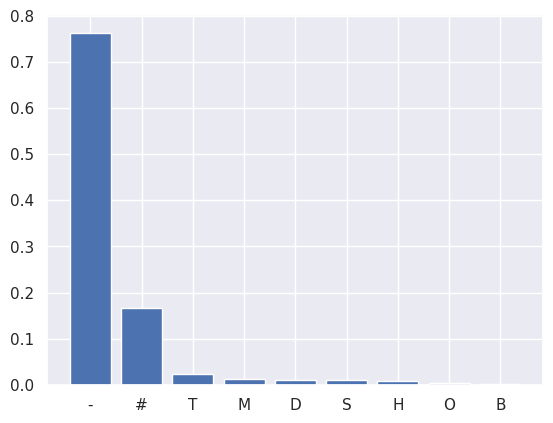

In [ ]:
# Data Analysis
with open('./data/id_to_idx.json') as json_file:
    enc_map: dict = json.load(json_file)["tiles"]
    reversed_enc_map = dict((v,k) for k,v in enc_map.items())
    print(reversed_enc_map)

frequencies = defaultdict(lambda: defaultdict(lambda:0))
cnt = 0
for game_key, data in all_datasets.items():
  print(game_key)
  for frame_name, frame_data in data.items():
    cnt += 1
    ans = Counter([x for sublist in frame_data for x in sublist])
    frequencies =  dict(Counter(frequencies)+Counter(ans))

freqs_01 = {}
sum_vals = 0
for value in frequencies.values():
  sum_vals += value

for key, value in frequencies.items():
  print(key, value)
  freqs_01[reversed_enc_map[key]] = value / sum_vals

srt = (dict(sorted(freqs_01.items(), reverse=True, key=lambda item: item[1])))
plt.bar(*zip(*srt.items()))
plt.show()

In [ ]:
print(srt)

{'-': 0.7632078651685393, '#': 0.16652808988764045, 'T': 0.023329588014981275, 'M': 0.012722846441947565, 'D': 0.010758426966292135, 'S': 0.010511235955056179, 'H': 0.00806367041198502, 'O': 0.0028689138576779025, 'B': 0.00200936329588015}


# **6- Load Images**

In [ ]:
""" load images """
images = dict()
for game_key in game_keys:
  # directory = f"./data/{game_key}/cropped_resized"
  directory = f"./data/{game_key}/cropped"
  print(f"Processing {game_key} data...")
  for file in os.listdir(directory):
      try:
        filename = os.fsdecode(file)
        if filename.endswith(".png"):
          img_bgr = cv2.imread(os.path.join(directory, filename))
          if CHANNELS == 3:
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
          else:
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

          img_rgb = cv2.resize(img_rgb, (IMG_WIDTH, IMG_HEIGHT))

          image = np.asarray(img_rgb)
          to_save = image.astype(np.uint8)
          images[f"{game_key}-{filename}"] = to_save
      except Exception as e:
        print(filename)
print(f"Number of images in the dataset: {len(images)}")

Processing kid_icarus data...
Processing smb data...
Number of images in the dataset: 3560


In [ ]:
limit = 2000
valid_start_ends = {}
for game_key in all_datasets.keys():
  if game_key in game_keys:
  # if game_key != TEST_GAME:
    game_dataset = all_datasets[game_key]
    if len(game_dataset) < 2000:
      start = int(0.9* len(game_dataset))
      end = len(game_dataset)
    else:
      start = 2001
      end = min(len(game_dataset), 2200)

    valid_start_ends[game_key] = (start, end)

print(valid_start_ends)

{'kid_icarus': (2001, 2145), 'smb': (1273, 1415)}


# **7 - Train/Validation/Test Splitting**

In [ ]:
num_classes = len(frequencies)
print("Number of individual tile types in the dataset: ", num_classes)

Number of individual tile types in the dataset:  9


In [ ]:
def shuffle(X, y, names):
  a = list(zip(X, y, names))
  python_random.shuffle(a)
  X, y, names= zip(*a)
  return list(X), list(y), list(names)


In [ ]:
X_train = []
y_train = []
X_train_frame_names = []

X_valid = []
y_valid = []
X_valid_frame_names = []

X_test = []
y_test = []
X_test_frame_names = []

def convert_to_float_np_arr(list):
  return np.asarray(list, dtype=np.double)

def convert_to_int_np_arr(list):
  return np.asarray(list, dtype=np.uint8)

for game_key in game_keys:
  game_dataset = all_datasets[game_key]
  num_of_game_frames = len(game_dataset)
  if game_key in game_keys:
  # if game_key != TEST_GAME:
    start, end = valid_start_ends[game_key]

  counter = -1

  for image_name in sorted(game_dataset.keys()):
    if image_name in images.keys():
      counter += 1
      # if TEST_GAME in image_name:
      #   X_test.append(images[image_name])
      #   y_test.append(game_dataset[image_name])
      #   X_test_frame_names.append(image_name)
      # elif counter < start:
      num_part = int(re.findall(r'\d+', image_name)[0])
      if (num_part < 5122 and game_key == "kid_icarus") or (num_part < 2720 and game_key == "smb"):
        X_train.append(images[image_name])
        y_train.append(game_dataset[image_name])
        X_train_frame_names.append(image_name)
      if (num_part >= 5122 and game_key == "kid_icarus") or (num_part >= 2720 and game_key == "smb"):
        X_valid.append(images[image_name])
        y_valid.append(game_dataset[image_name])
        X_valid_frame_names.append(image_name)

In [ ]:
def count_frames(data):
  frames_cnt = {game_key:0 for game_key in game_keys}
  for frame in data:
    for game_key in game_keys:
      if game_key in frame:
        frames_cnt[game_key] += 1

  print(frames_cnt)
  return frames_cnt

counts = count_frames(X_train_frame_names)
diff = counts["kid_icarus"] - counts["smb"]

while diff > 0 :
  idx = python_random.choice(range(len(X_train)))
  name = X_train_frame_names[idx]
  if "smb" in name:
    diff -= 1
    X_train.append(X_train[idx])
    X_train_frame_names.append(name)
    y_train.append(y_train[idx])

count_frames(X_train_frame_names)

{'kid_icarus': 1978, 'smb': 1222}
{'kid_icarus': 1978, 'smb': 1978}


{'kid_icarus': 1978, 'smb': 1978}

In [ ]:
print("X_train length: ", len(X_train))
print("y_train length: ", len(y_train))
print("X_train_frame_length: ", len(X_train_frame_names))

X_train length:  3956
y_train length:  3956
X_train_frame_length:  3956


['-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-']
['-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-']
['-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-']
['-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-']
['-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-']
['#' '-' '-' '#' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-']
['#' '-' '-' '#' '#' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-']
['#' '-' '-' '#' '#' '#' '-' '-' '-' '-' '-' 'D' 'D' '-' '-']
['#' '-' '-' '#' '#' '#' '#' '-' '-' '-' '-' 'D' 'D' '-' '-']
['#' '-' '-' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#']
Number of images in the dataset: 3560
Shape of X_train: (3956, 50, 75, 3)
Shape of y_train: (3956, 10, 15, 9)
Shape of X_valid: (360, 50, 75, 3)
Shape of y_valid: (360, 10, 15, 9)


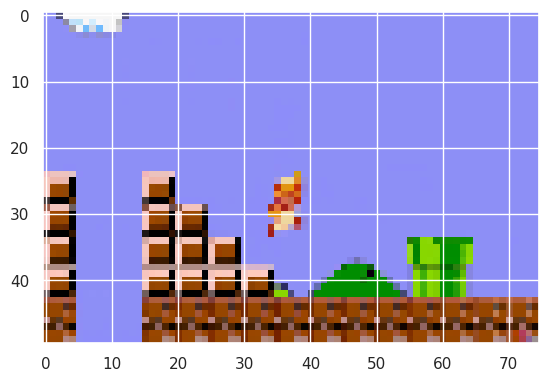

In [ ]:
# Shuffle Data
X_train, y_train, X_train_frame_names= shuffle(X_train, y_train, X_train_frame_names)

X_valid, y_valid, X_valid_frame_names = shuffle(X_valid, y_valid, X_valid_frame_names)

# X_test, y_test, X_test_frame_names = shuffle(X_test, y_test, X_test_frame_names)


plt.imshow(X_train[159])
for row in np.vectorize(reversed_enc_map.get)(y_train[159]):
  print(row)


DIVIDE_BY = 255

X_train = convert_to_float_np_arr(X_train) / DIVIDE_BY
y_train_numerical = convert_to_int_np_arr(y_train)
y_train = keras.utils.to_categorical(
    y_train_numerical-1, num_classes = num_classes
)

X_valid = convert_to_float_np_arr(X_valid) / DIVIDE_BY
y_valid_numerical = convert_to_int_np_arr(y_valid)
y_valid = keras.utils.to_categorical(
    y_valid_numerical-1, num_classes = num_classes
)

# X_test = convert_to_float_np_arr(X_test) / DIVIDE_BY
# y_test_numerical = convert_to_int_np_arr(y_test)
# y_test = keras.utils.to_categorical(
#     y_test_numerical-1, num_classes = num_classes
# )

print(f"Number of images in the dataset: {len(images)}")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_valid: {X_valid.shape}")
print(f"Shape of y_valid: {y_valid.shape}")
# print(f"Shape of X_test: {X_test.shape}")
# print(f"Shape of y_test: {y_test.shape}")


## Compute Sample Weights

In [ ]:
weight_mapping = {}

for key, value in frequencies.items():
  weight_mapping[key]= max(round(np.log((1/(value/sum_vals)))), 1)

# weight_mapping = {
#     1: 1,
#     2: 1,
#     3: 1,
#     4: 1,
#     5: 1,
#     6: 1,
#     7: 8,
#     8: 1,
#     9: 8,
# }
print(weight_mapping)
sample_weight = np.ones(y_train_numerical.shape)
print(sample_weight.shape)

def custom_map(source, mapping):
  out = []
  for line in instance:
    out.append(list(map(mapping.get, line)))
  return out

for (index, instance) in enumerate(y_train_numerical):
    sample_weight[index] = custom_map(instance, weight_mapping)

print(" y_train shape: ", y_train.shape, " sample_weights shapes: ", sample_weight.shape)
print(" y_valid shape: ", y_valid.shape)

{1: 2, 2: 1, 6: 4, 3: 5, 4: 5, 5: 4, 8: 5, 9: 6, 7: 6}
(3956, 10, 15)
 y_train shape:  (3956, 10, 15, 9)  sample_weights shapes:  (3956, 10, 15)
 y_valid shape:  (360, 10, 15, 9)


In [ ]:
# print(y_train[0].shape)
# print(y_train[0][0][0])
# x1 = np.tile(y_train[0][0][0], (10, 15, 5))
# x2 = np.tile(y_train[1][0][0], (10, 15, 5))
# x3 = np.tile(y_train[2][0][0], (10, 15, 5))
# print((x1==x2).all())
# print((x1==x3).all())
# print((x2==x3).all())

### Visualize Random Images From the Dataset

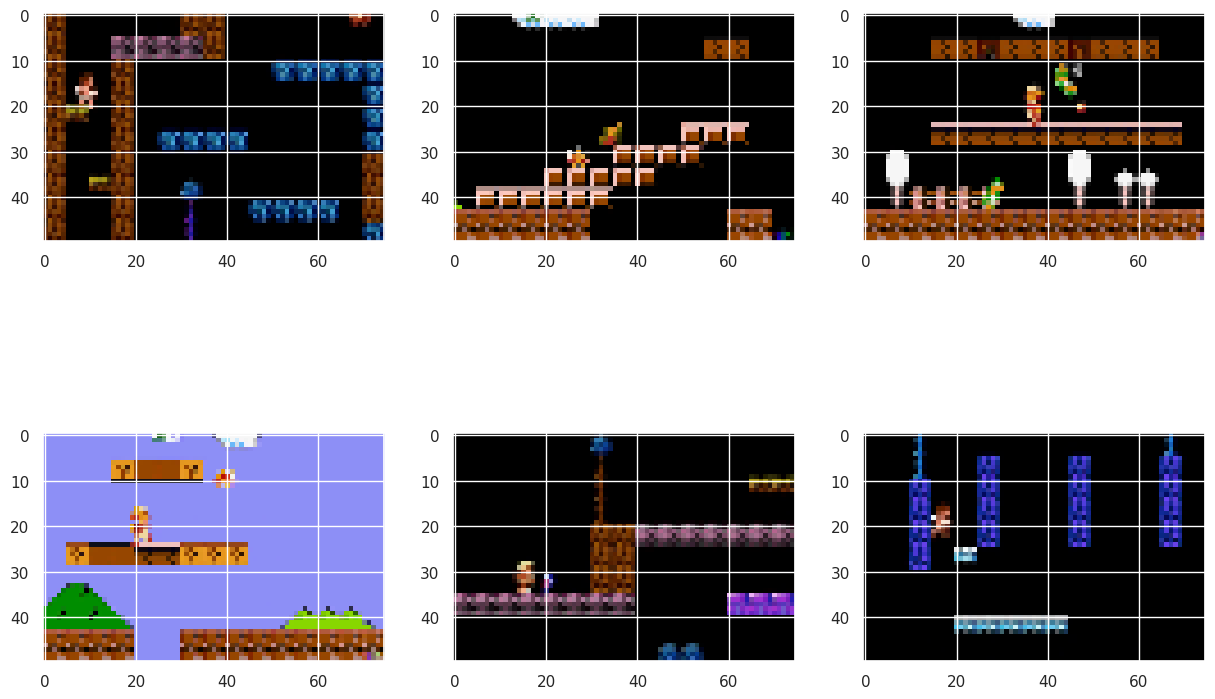

In [ ]:
from IPython.display import display # to display images

fig = plt.figure( figsize=(15, 10))
for i in range(6):
  sample_image = python_random.choice(list(X_train))
  ax1 = fig.add_subplot(2 , 3, i+1)
  ax1.imshow(sample_image, cmap='gray')

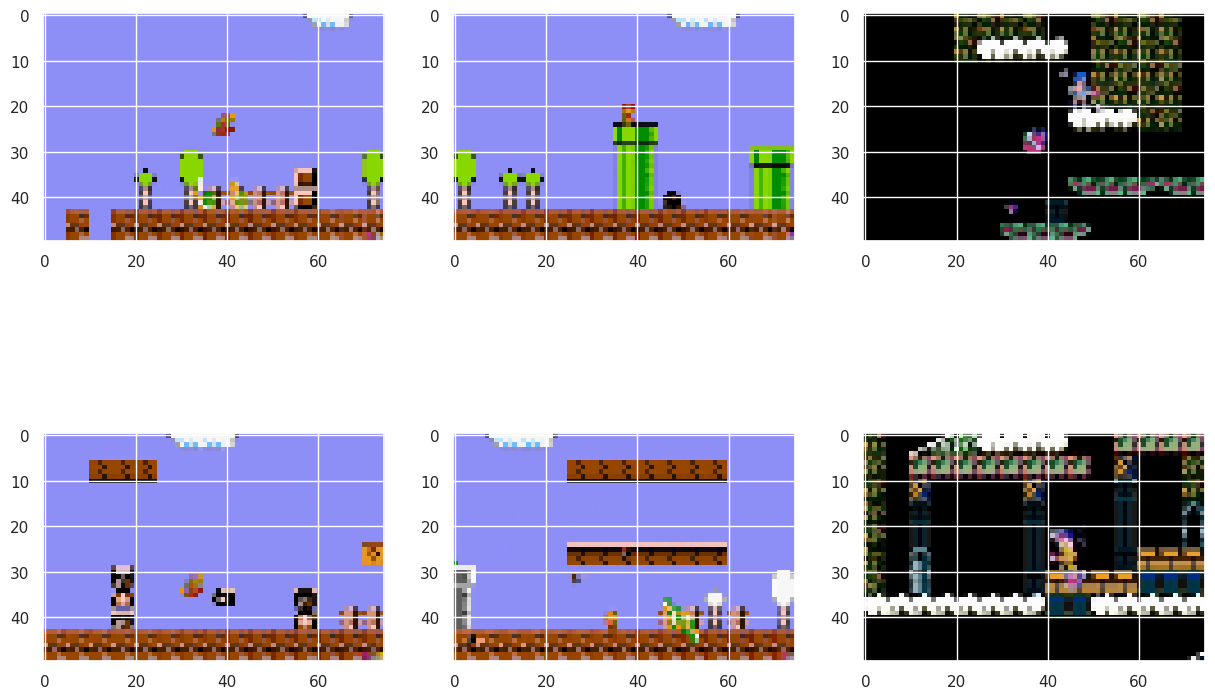

In [ ]:
# Display images from the validation set
fig = plt.figure( figsize=(15, 10))
for i in range(6):
  sample_image = python_random.choice(list(X_valid))
  ax1 = fig.add_subplot(2 , 3, i+1)
  ax1.imshow(sample_image)

## Model Definition

### Inception Module Defintion

In [ ]:
from keras.initializers import RandomNormal
init = RandomNormal(mean=0.0, stddev=0.02, seed = init_seed)

In [ ]:
def inception_module(layer_in, f1, f2, f3, f4, strides, transpose=False, random_norm_init=True):
  alpha=0.1
  if not transpose:
    layer = keras.layers.Conv2D
  else:
    layer = keras.layers.Conv2DTranspose

  if random_norm_init:
     kernel_initializer='glorot_uniform'
  else:
     kernel_initializer=init

  # 1x1 conv
  conv1 = layer(f1, (1,1), padding='same', strides=strides,
                              use_bias='True',
                              kernel_initializer=kernel_initializer
                              )(layer_in)
  # 3x3 conv
  conv3 = layer(f2, (3,3), padding='same', strides=strides,
                              use_bias='True',
                              kernel_initializer=kernel_initializer
                              )(layer_in)
  # 5x5 conv
  conv5 = layer(f3, (5,5), padding='same', strides=strides,
                              use_bias='True',
                              kernel_initializer=kernel_initializer
                              )(layer_in)

  # 7x7 conv
  conv7 = layer(f4, (7,7), padding='same', strides=strides,
                              use_bias='True',
                              kernel_initializer=kernel_initializer,
                              )(layer_in)
	# concatenate filters, assumes filters/channels last
  layer_out = Concatenate(axis=-1)([conv1, conv3, conv5, conv7])
  return layer_out

## Define Main Hyperparameters

In [ ]:
rows = X_train.shape[1] #@param
columns = X_train.shape[2] #@param
channel = CHANNELS #@param
latent_dim = 128 #@param
depth = 8 #@param
KERNEL = 5 #@param

# **Encoder**

In [ ]:
from keras import metrics, backend as K

def sampling(args):
    mean, logsigma = args
    batch = tf.shape(mean)[0]
    dim = tf.shape(mean)[1]
    epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=1.0)
    return mean + K.exp(logsigma / 2) * epsilon

In [ ]:
def encoder(kernel, filter, rows, columns, channel, latent_dim=latent_dim, alpha=0.2, dropout=0.2):
    input = keras.layers.Input(shape=(rows, columns, channel))
    x = inception_module(input, filter, filter, filter, filter, 1, False, False)
    x = keras.layers.BatchNormalization(fused=False)(x)
    x = keras.layers.LeakyReLU(alpha)(x)
    x = keras.layers.Dropout(dropout)(x)


    x = inception_module(x, filter*2, filter*2, filter*2, filter*2, 5, False, False)
    x = keras.layers.BatchNormalization(fused=False)(x)
    x = keras.layers.LeakyReLU(alpha)(x)
    x = keras.layers.Dropout(dropout)(x)

    x = inception_module(x, filter*2, filter*2, filter*2, filter*2, 5, False, False)

    x = keras.layers.BatchNormalization(fused=False)(x)
    x = keras.layers.LeakyReLU(alpha)(x)
    x = keras.layers.Dropout(dropout)(x)

    x = keras.layers.Flatten()(x)
    mean = keras.layers.Dense(latent_dim, kernel_initializer=init, name="z_mean")(x)
    logsigma = keras.layers.Dense(latent_dim, activation='relu', name="z_log_var")(x)
    latent = keras.layers.Lambda(sampling, output_shape=(latent_dim,))([mean, logsigma])
    model = keras.models.Model([input], [mean, logsigma, latent], name="encoder")
    print(model.summary())
    return model

In [ ]:
# encoder
ENC = encoder(KERNEL, depth, rows, columns, channel)
ENC.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 50, 75, 8)    32          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 50, 75, 8)    224         ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 50, 75, 8)    608         ['input_1[0][0]']                
                                                                                            

# **Decoder/Generator**

In [ ]:
def dec_gen(kernel, filter, rows, columns, latent_dim=128,
            alpha=0.2, dropout=0.2, use_batch_norm=False):
    input = keras.layers.Input(shape=(latent_dim,))
    x = keras.layers.Dense(rows * columns * filter, activation='relu')(input)

    x = keras.layers.Reshape((rows, columns, filter))(x)
    x = keras.layers.LeakyReLU(alpha)(x)
    x = keras.layers.Dropout(dropout)(x)
    if use_batch_norm:
      x = keras.layers.BatchNormalization(fused=False)(x)

    x = inception_module(x, filter*2, filter*2, filter*2, filter*2, 1, True)
    x = keras.layers.LeakyReLU(alpha)(x)
    x = keras.layers.Dropout(dropout)(x)
    if use_batch_norm:
      x = keras.layers.BatchNormalization(fused=False)(x)

    x = inception_module(x, filter, filter, filter, filter, 1, True)
    x = keras.layers.LeakyReLU(alpha)(x)
    x = keras.layers.Dropout(dropout)(x)
    if use_batch_norm:
      x = keras.layers.BatchNormalization(fused=False)(x)

    x = keras.layers.Conv2DTranspose(filters=num_classes, kernel_size=kernel,
                                     strides=1, padding='same',
                                     activation="softmax",
                                     kernel_initializer=init
                                     )(x)


    model = keras.models.Model(input, x, name="decoder")
    assert model.output_shape == (None, 10, 15, num_classes)
    print(model.summary())
    return model

In [ ]:
def generate_random_tensor(num_samples, dim):
  return tf.random.normal([num_samples, dim])

### Create instances of the decoder and the generator

In [ ]:
# print(generated_trans[0].shape)
# print(y_train.shape)
x = np.random.rand(2, 2, 3, 2)
y = np.random.rand(2, 3, 2)
# print("x=", x)
# print("y=", y)
mean = np.square(np.subtract(x, y)).mean(axis=(1, 2, 3))
print(mean)
print(min(mean))


from sklearn.metrics import mean_squared_error
mse = tf.keras.losses.MeanSquaredError()
test = mse(x, y).numpy()
print(test)

[0.2297887  0.09103851]
0.09103851419983448
0.16041360523830037


In [ ]:
# Decoder
DEC = dec_gen(KERNEL, depth, 10, 15, latent_dim, 0.1)

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 1200)         154800      ['input_2[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 10, 15, 8)    0           ['dense[0][0]']                  
                                                                                                  
 leaky_re_lu_3 (LeakyReLU)      (None, 10, 15, 8)    0           ['reshape[0][0]']                
                                                                                            

# **Define Schedulers**

In [ ]:
def frange_cycle_cosine(start, stop, n_epoch, n_cycle=4, ratio=0.5):
    L = np.ones(n_epoch)
    period = n_epoch/n_cycle
    step = (stop-start)/(period*ratio) # step is in [0,1]

    # transform into [0, pi] for plots:

    for c in range(n_cycle):

        v , i = start , 0
        while v <= stop:
            L[int(i+c*period)] = 0.5-.5*math.cos(v*math.pi)
            v += step
            i += 1
    return L

# **Callbacks**

In [ ]:
mum_seeds = 100
seed_64 = generate_random_tensor(mum_seeds, 64)
seed_128 = generate_random_tensor(mum_seeds, 128)
seed_256 = generate_random_tensor(mum_seeds, 256)

def get_seed(latent_dim):
  if latent_dim == 64:
      return seed_64
  elif latent_dim == 128:
      return seed_128
  elif latent_dim == 256:
      return seed_256
  else:
    raise Exception()


class GenerateCallback(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
      if epoch % 5 == 0:
        keys = list(logs.keys())
        seed = get_seed(self.model.latent_dim)
        generate_and_save_images(self.model.decoder, seed, 8)

class AssignBettaCallback(keras.callbacks.Callback):
  def __init__(self, n_epoch):
    self.betta_range = frange_cycle_cosine(0.0, 1.0, n_epoch, 4)
    plt.plot(range(n_epoch), self.betta_range)

  def on_epoch_begin(self, epoch, logs=None):
    self.model.betta = self.betta_range[epoch]

class AlternateTrainingCallback(keras.callbacks.Callback):
    def __init__(self, start_ep, alternate_rate=2):
      self.start_ep = start_ep
      self.alternate_rate = alternate_rate

    def on_epoch_begin(self, epoch, logs=None):
      if epoch >= self.start_ep:
        if epoch % self.alternate_rate != 0:
          make_untrainable(self.model.discriminator)
          make_trainable(self.model.generator)
          print("num DISC trainable vars", count_params(self.model.discriminator.trainable_weights))
        else:
          make_untrainable(self.model.generator)
          make_trainable(self.model.discriminator)
          print(" Num GEN trainable vars", count_params(self.model.generator.trainable_weights))

class SaveModelCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
      if (epoch + 1) % 10 == 0:
        self.model.encoder.save_weights(f'./double_check/periodic/vae/{str(init_seed)}/encoder_checkpoints.{epoch+1:03d}')
        self.model.decoder.save_weights(f'./double_check/periodic/vae/{str(init_seed)}/decoder_checkpoints.{epoch+1:03d}')

## **Define the VAE_GAN model**

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, latent_dim):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

        self.latent_dim = latent_dim

        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.normal_loss_tracker = keras.metrics.Mean(name="normal_loss")

        self.betta = 1

    @property
    def metrics(self):
        # List the `Metric` objects here so that `reset_states()`
        # can be called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        return [
                self.normal_loss_tracker,
                self.kl_loss_tracker,
                ]

    def compile(self, e_optimizer, dec_optimizer, categorical_loss_fn):
        super(VAE, self).compile()
        self.e_optimizer = e_optimizer
        self.dec_optimizer = dec_optimizer

        self.categorical_loss_fn = categorical_loss_fn

    def call(self, inputs, *args, **kwargs):
        _, _, temp = self.encoder(inputs)
        return self.decoder(temp)


    # Notice the use of `tf.function`
    # This annotation causes the function to be "compiled".
    @tf.function
    def train_step(self, data):
        if len(data) == 3:
            x, y, sample_weight = data
        else:
            sample_weight = None
            x, y = data

        ################## PASS 1: Reconstruction ##########################
        # generate a random noise batch
        z_p =  generate_random_tensor(len(x), self.latent_dim)

        with tf.GradientTape() as enc_tape , tf.GradientTape() as dec_tape:
            # pass the real images to encoder -> decoder -> discriminator
            z_mean, z_log_var, z = self.encoder(x)
            x_tilde = self.decoder(z)

            # Calculate the normal reconstruction loss
            normal_loss = self.categorical_loss_fn(y, x_tilde, sample_weight)

            # Calculate the Prior(KL) loss
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            # Assign the VAE loss
            total_loss = normal_loss + kl_loss

        ENC_grad = enc_tape.gradient(total_loss, self.encoder.trainable_variables)
        DEC_grad = dec_tape.gradient(total_loss, self.decoder.trainable_variables)
        self.e_optimizer.apply_gradients(zip(ENC_grad, self.encoder.trainable_variables))
        self.dec_optimizer.apply_gradients(zip(DEC_grad, self.decoder.trainable_variables))

        self.kl_loss_tracker.update_state(kl_loss)
        self.normal_loss_tracker.update_state(normal_loss)

        return {
            "kl_loss" : self.kl_loss_tracker.result(),
            "normal_loss": self.normal_loss_tracker.result(),
        }

## **Define the Loss Functions**

In [ ]:
# The from_logits=True attribute inform the loss function that the output values
# generated by the model are not normalized, a.k.a. logits. In other words, the
# softmax function has not been applied on them to produce a probability
# distribution.
cross_entropy = tf.keras.losses.BinaryCrossentropy(reduction='sum_over_batch_size')
cat_loss = tf.keras.losses.CategoricalCrossentropy(reduction="none")

mse = tf.keras.losses.MeanSquaredError()

# example of smoothing class = 1 to [0.9, 1]
def smooth_positive_labels(y):
  return y - 0.1 + (tf.random.uniform(tf.shape(y)) * 0.1)

# def discriminator_loss(real_output, fake_output):
#     real_loss = cross_entropy(smooth_positive_labels(tf.ones_like(real_output)), real_output)
#     fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
#     total_loss = real_loss + fake_loss
#     return total_loss


# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_d, fake_d):
    real_loss = tf.reduce_mean(real_d)
    fake_loss = tf.reduce_mean(fake_d)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_d):
    return -tf.reduce_mean(fake_d)


# def generator_loss(fake_output):
#     return cross_entropy(tf.ones_like(fake_output), fake_output)

def custom_categorical_loss(y_true, y_pred, sample_weight=None):
    reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(
            cat_loss(y_true, y_pred, sample_weight), axis=(1, 2)
        )
    )
    return reconstruction_loss

def disl_loss(dis_inner_true, dis_inner_tilde):
   print("dis_inner_true shape", dis_inner_true.shape, "dis_inner_tilde", dis_inner_tilde.shape)
   mse_loss = mse(dis_inner_tilde, dis_inner_true)
   print("mse_loss_shape", mse_loss.shape, mse)
   return mse_loss

## Define the Hyper GAN model

In [ ]:
class HyperVAE(kt.HyperModel):

  def __init__(self, dataset):
        super(HyperVAE, self).__init__()
        self.MSE = tf.keras.losses.MeanSquaredError()
        self.dataset = dataset

  def build(self, hp):

    hp_latent_dim = hp.Choice('latent_dim', [64, 128, 256])
    hp_dropout_vae = hp.Float('dropout rate vae', min_value = 0.01, max_value = 0.5)

    hp_alpha = hp.Float('alpha rate', min_value = 0, max_value = 0.3)
    # hp_batch_norm = hp.Boolean('batch normalization')
    hp_depth_vae = hp.Choice("depth_vae", [2, 4, 8])

    # with hp.conditional_scope("depth_gen", [2, 4, 8]):
    #   if hp_depth_gen == 2:
    #     hp_depth_disc = hp.Choice("depth_disc", [2, 4,])
    #   elif hp_depth_gen == 4:
    #           hp_depth_disc = hp.Choice("depth_disc", [4, 8,])
    #   elif hp_depth_gen == 8:
    #     hp_depth_disc = hp.Choice("depth_disc", [8, 16,])
    # hp_learning_rate_vae = hp.Choice('vae_learning_rate', values=[3e-4, 3e-5, 1e-4])

    self.encoder = encoder(kernel=KERNEL, filter=hp_depth_vae, rows=rows, columns=columns,
                           channel=channel, latent_dim=hp_latent_dim, alpha=hp_alpha,
                           dropout=hp_dropout_vae
                           )

    self.decoder = dec_gen(kernel=KERNEL, filter=hp_depth_vae, rows=10, columns=15,
                           latent_dim=hp_latent_dim, alpha=hp_alpha, dropout=hp_dropout_vae
                           )



    vae = VAE(self.encoder, self.decoder, hp_latent_dim)
    vae.compile(
          e_optimizer=keras.optimizers.Adam(),
          dec_optimizer=keras.optimizers.Adam(),
          categorical_loss_fn=custom_categorical_loss,
    )

    return vae

  def fit(self, hp, model, *args, **kwargs):
        model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [8, 16, 32]),
            **kwargs,
        )
        seed = get_seed(model.latent_dim)
        generated_images = self.decoder(seed, training=False)
        mse_score = self.calculate_score(model, generated_images, kwargs["validation_data"])
        # Return a single float to minimize.
        return mse_score


  def calculate_score(self, model, generated_images, validation_data):

    generated_trans_numerical = (np.argmax(generated_images, axis = -1)).astype(dtype=np.double)
    generated_trans_categorical = keras.utils.to_categorical(
        generated_trans_numerical, num_classes = num_classes
    )
    total_MSE  = 0
    cnt = 0
    for item in generated_trans_categorical:
      cnt+=1

      min_MSE = float('inf')
      replicated = np.tile(item[0][0], (10, 15)) .reshape((10, 15, num_classes))
      all_values_are_same = (replicated==item).all()

      if not all_values_are_same:
        mse_s = np.square(np.subtract(self.dataset, item)).mean(axis=(1, 2, 3))
        min_MSE = min(mse_s)
        total_MSE += min_MSE
      else:
        return float('inf')

    total_MSE /= len(generated_images)

    # x_valid, y_valid = validation_data
    # _, _, temp = model.encoder(x_valid)
    # out = model.decoder(temp)
    # metric = tfa.metrics.F1Score(num_classes=num_classes)
    # metric.update_state(y_valid.reshape(y_valid.shape[0], y_valid.shape[1]*y_valid.shape[2], y_valid.shape[3]),
    #                     out.reshape(y_valid.shape[0], y_valid.shape[1]*y_valid.shape[2], y_valid.shape[3]))
    # valid_macro_f1 = metric.result().numpy()
    # print("**********************************")
    # print("valid macro f1_score:", valid_macro_f1)
    # print("Total Score:", total_MSE)
    # print("**********************************")
    return total_MSE
    # return total_MSE + (1 - valid_macro_f1)/20

In [ ]:
def generate_and_save_images(generator, test_input, num_samples=4):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  to_return = []
  predictions = generator(test_input, training=False)
  to_print = [ []*1 for i in range(10)]
  print("Random generated samples:", flush=True)
  for i in range(num_samples):
      generated_trans_numerical = (np.argmax(predictions[i], axis = -1) + 1).astype('int')
      decoded_pred = list(np.vectorize(reversed_enc_map.get)(generated_trans_numerical))
      to_return.append(decoded_pred)
      for idx, row in enumerate(decoded_pred):
        to_print[idx] +=  "".join(row) + "        "
  for line in to_print:
    print("".join(line))
  print("-----------------------------------------------------------")
  return to_return


In [ ]:
def plot_accuracies(history):
  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title('model accuracy per epoch')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()


def plot_losses(history, key):
  plt.plot(history[key])
  plt.title(f'model {key} per epoch')
  plt.ylabel(key)
  plt.xlabel('epoch')
  plt.show()

In [ ]:
gen_callback_obj = GenerateCallback()

In [ ]:
trials = 10

if TUNE_FIRST:
  tuner = kt.BayesianOptimization(
      hypermodel=HyperVAE(dataset=y_train),
      # No objective to specify.
      # Objective is the return value of `HyperModel.fit()`.
      seed = init_seed,
      max_trials=trials,
      overwrite=True,
      directory="my_dir",
      project_name="tune_vae",
  )
  tuner.search(
      x = X_train, y = y_train, epochs=50, validation_data=(X_valid, y_valid),
      sample_weight=sample_weight, callbacks=[
                                              gen_callback_obj,
                                              keras.callbacks.TensorBoard("/tmp/tb_logs"),
                                              ]
      )

else:
  tuner = kt.BayesianOptimization(
      hypermodel=HyperVAE(dataset=y_train),
      # No objective to specify.
      # Objective is the return value of `HyperModel.fit()`.
      seed = init_seed,
      max_trials=trials,
      overwrite=False,
      directory="my_dir",
      project_name="tune_vae",
  )


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50, 75, 3)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 50, 75, 2)    8           ['input_3[0][0]']                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 50, 75, 2)    56          ['input_3[0][0]']                
                                                                                                  
 conv2d_14 (Conv2D)             (None, 50, 75, 2)    152         ['input_3[0][0]']                
                                                                                            

In [ ]:
tuner.results_summary()

Results summary
Results in my_dir/tune_vae
Showing 10 best trials


In [ ]:
%load_ext tensorboard

%tensorboard --logdir /tmp/tb_logs

# **Retrain the Model With Best Hyperparameter**

In [ ]:
# best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps = kt.HyperParameters()
pp = pprint.PrettyPrinter(depth=4)
pp.pprint(best_hps.values)
# hp_batch_size = best_hps.values['batch_size']

{}


In [ ]:
if not TUNE_FIRST:
  best_hps.values['batch_size'] = 8
  best_hps.values['alpha rate'] =  0.14732279576819815
  best_hps.values['batch_size'] = 8
  best_hps.values['depth_vae'] = 2
  best_hps.values['latent_dim'] =  128
  best_hps.values['dropout rate vae'] =  0.24261279625229554

hp_batch_size = best_hps.values['batch_size']

In [ ]:
pp.pprint(best_hps.values)

{'alpha rate': 0.14732279576819815,
 'batch_size': 8,
 'depth_vae': 2,
 'dropout rate vae': 0.24261279625229554,
 'latent_dim': 128}


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 50, 75, 3)]  0           []                               
                                                                                                  
 conv2d_24 (Conv2D)             (None, 50, 75, 2)    8           ['input_5[0][0]']                
                                                                                                  
 conv2d_25 (Conv2D)             (None, 50, 75, 2)    56          ['input_5[0][0]']                
                                                                                                  
 conv2d_26 (Conv2D)             (None, 50, 75, 2)    152         ['input_5[0][0]']                
                                                                                            

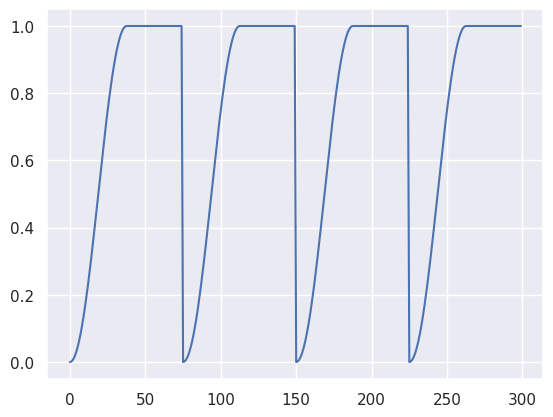

In [ ]:
n_epochs = 300
model = tuner.hypermodel.build(best_hps)
alt_callback_obj = AlternateTrainingCallback(100, 2)
assign_betta_callback_obj = AssignBettaCallback(n_epochs)
sv_model = SaveModelCallback()

In [ ]:
# history = model.fit(X_train, y_train,
#                     epochs=n_epochs,
#                     batch_size=hp_batch_size,
#                     sample_weight=sample_weight,
#                     callbacks=[gen_callback_obj,
#                                assign_betta_callback_obj,
#                                keras.callbacks.TensorBoard("/tmp/tb_logs"),
#                                sv_model,
#                                ]
# )

In [ ]:
# for key in history.history.keys():
#   plot_losses(history.history, key)

In [ ]:
model.encoder.load_weights(f'./double_check/periodic/vae/{str(init_seed)}/encoder_checkpoints.300')
model.decoder.load_weights(f'./double_check/periodic/vae/{str(init_seed)}/decoder_checkpoints.300')

# **Visualize a few generations with tiles from the general tile set**

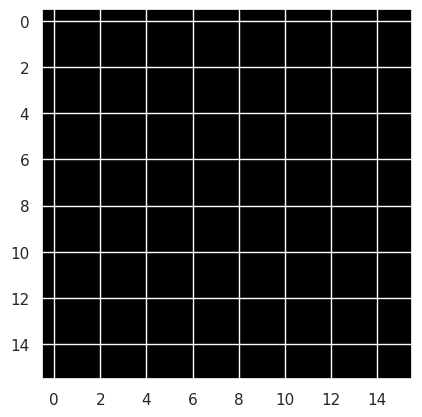

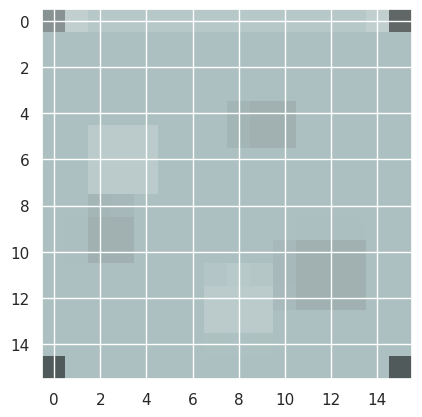

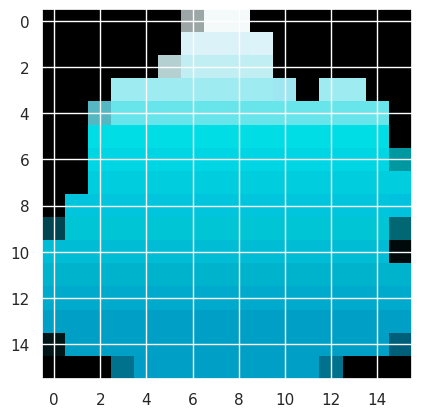

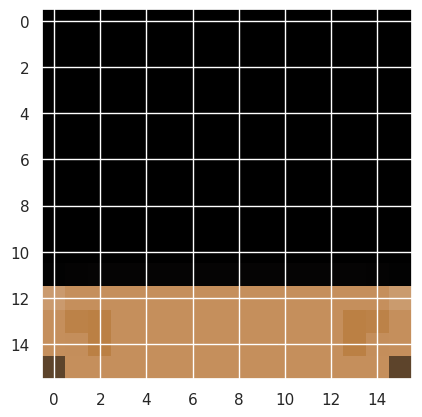

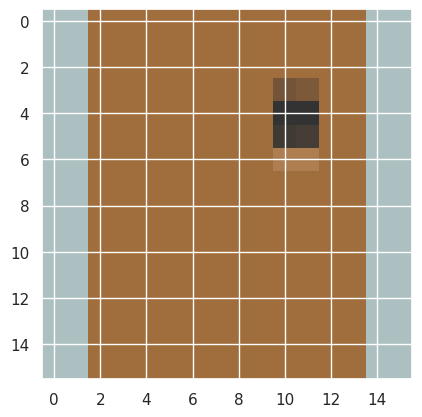

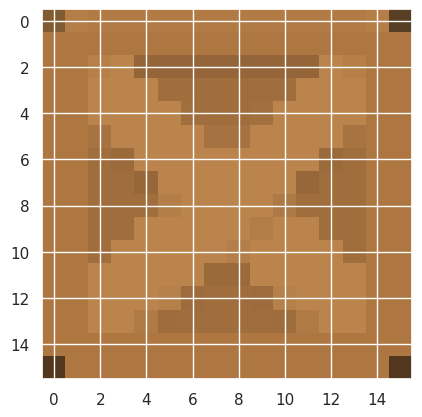

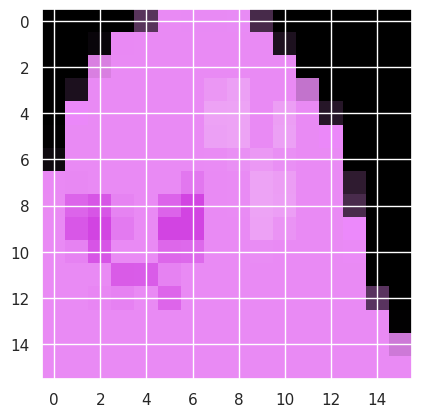

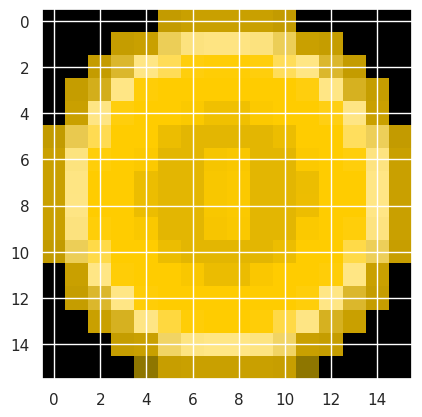

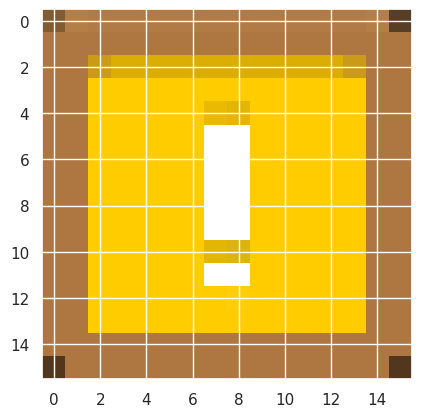

In [ ]:
all_datasets = {}
tiles = dict()
for key in srt.keys():
  img_obj = cv2.imread(f"./data/general_tile_set/{key}.png")
  img_obj = cv2.cvtColor(img_obj, cv2.COLOR_BGR2RGB)
  img_obj = cv2.resize(img_obj, (16, 16))
  tiles[key] = img_obj
  plt.imshow(img_obj)
  plt.show()

Random generated samples:
---------------        ---------------        ---------------        ---------------        ---------------        ---------------        ---------------        ---------------        ------O--------        ---------------        ---------------        ---------------        ---------------        #--------------        ---------------        ---------------        ---------------        -------------##        #----###-------        ---------------        ---------------        ---------------        ---------------        ---------------        ---------------        ---------------        ---------------        ---------------        ---------------        ---------------        ---------------        ---------------        ---------------        ---------------        ---------------        ---------------        ---------------        ---------------        ---------------        ---------------        ---------------        ---------------        --------

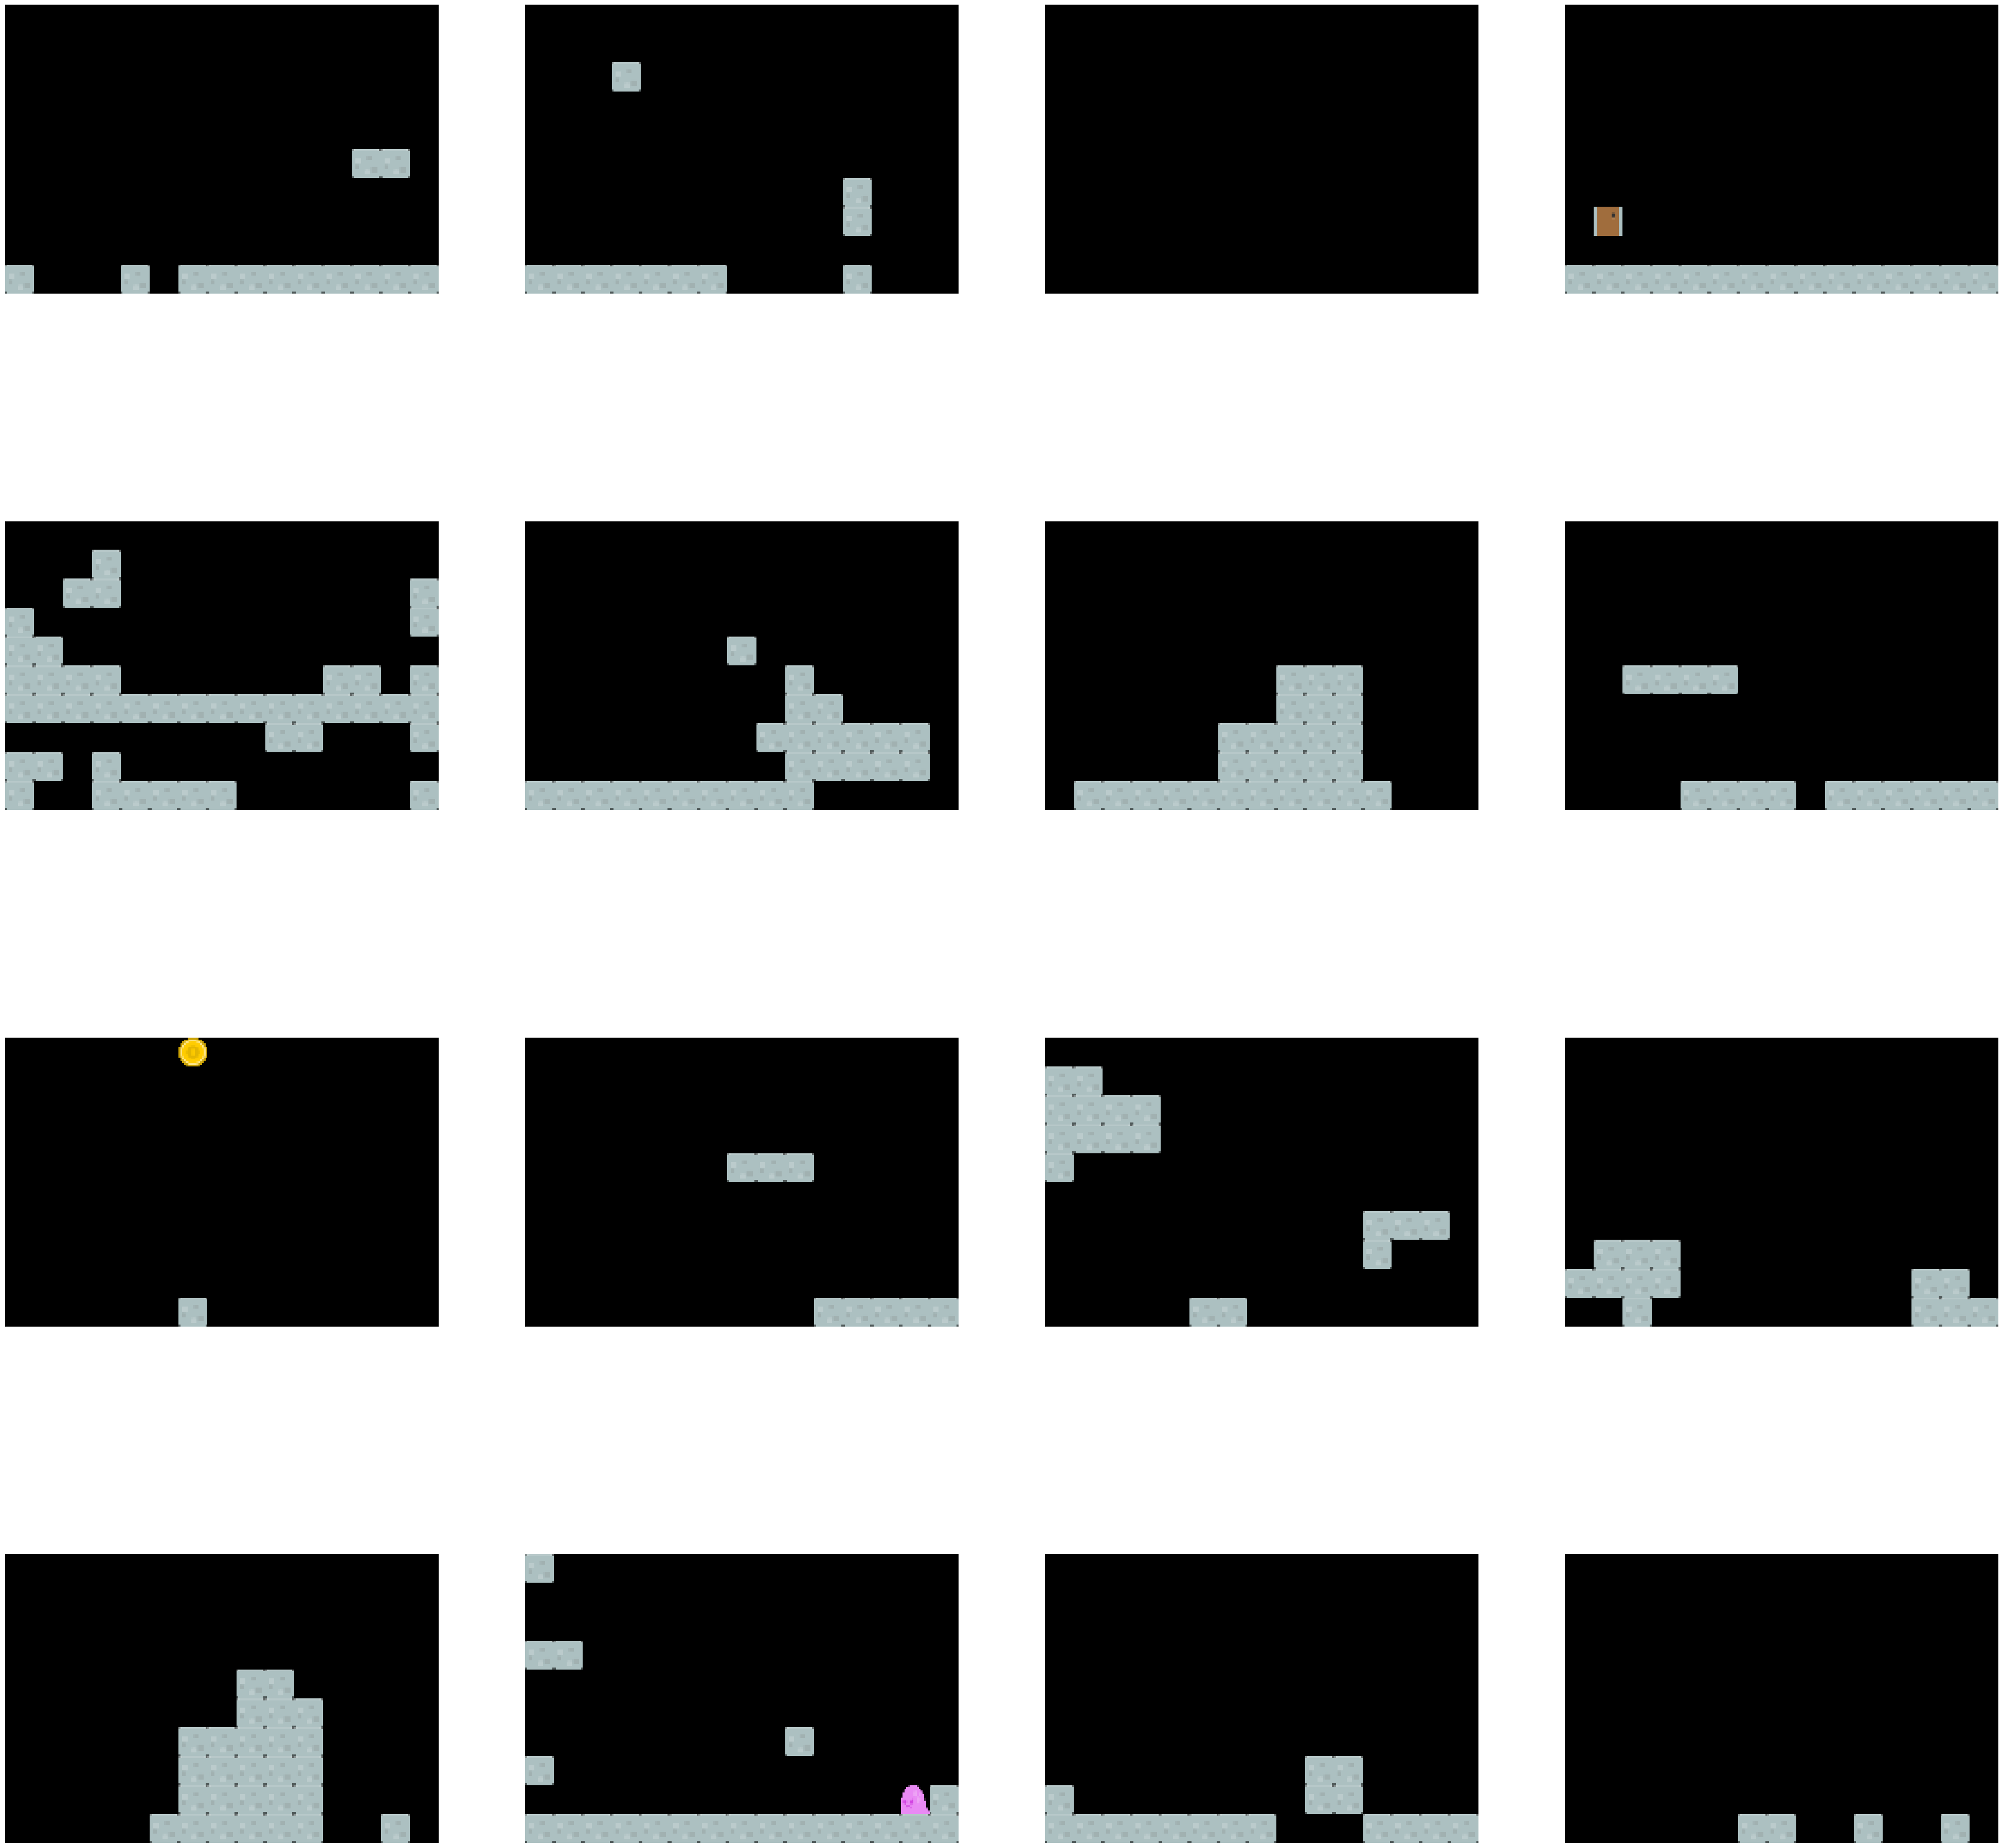

In [ ]:
num_seeds  = len(X_train)
a = generate_and_save_images(model.decoder, generate_random_tensor(num_seeds, model.latent_dim), num_seeds)
f, axarr = plt.subplots(4, 4, figsize=(50, 50))

# visualize 16 first examples
for i in range(16):
  img_rows = []
  for row in a[i]:
    img_rows.append(np.hstack([tiles[x] for x in row]))

  whole = np.vstack([x for x in img_rows])
  cnv = np.base_repr(i, base=4)
  first = int(0 if len(cnv) == 1 else cnv[0])
  second = int(cnv[0] if len(cnv) == 1 else cnv[1])
  axarr[first, second].axis("off")
  axarr[first, second].imshow(whole)




In [ ]:
# from datetime import datetime

# date = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
# with open(f'double_check/generations/{str(init_seed)}/vae_ks_{date}.pkl', 'wb') as f:
#   pickle.dump(a, f)

In [ ]:
# a_real = list(np.vectorize(reversed_enc_map.get)(y_train_numerical))
# num_samples = len(X_train)
# smb_data = []
# ki_data = []

# while len(smb_data) < num_samples/2 or len(ki_data) < num_samples/2:
#   a_random = python_random.choice(range(len(a_real)))
#   if "smb" in X_train_frame_names[a_random] and len(smb_data) < num_samples/2:
#     smb_data.append(a_real[a_random])
#   elif "kid_icarus" in X_train_frame_names[a_random] and len(ki_data) < num_samples/2:
#     ki_data.append(a_real[a_random])

# print(len(smb_data), len(ki_data))
# date = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
# with open(f'double_check/generations/{str(init_seed)}/real_dataset_smb{date}.pkl', 'wb') as f:
#   pickle.dump(smb_data, f)

# with open(f'double_check/generations/{str(init_seed)}/real_dataset_ki{date}.pkl', 'wb') as f:
#   pickle.dump(ki_data, f)

# **Evaluate the Performance of Encoder-Decoder**

In [ ]:
def dump_accuracies(predictions, names, real_y, keyword):
  accuracies = {}
  for i, name in enumerate(names):
    sample = predictions[i]
    y_pred = tf.one_hot(tf.argmax(sample, axis=2), depth = num_classes)
    acc = keras.metrics.CategoricalAccuracy()
    acc.update_state(real_y[i], y_pred)
    accuracies[name] = acc.result().numpy()
  with open(f'./accuracies/vae_{keyword}_accuracies.pickle', 'wb') as handle:
      pickle.dump(accuracies, handle, protocol=pickle.HIGHEST_PROTOCOL)
      print(len(accuracies))

In [ ]:
# Training Accuracy
z, _, _ = model.encoder.predict(X_train)
predictions = model.decoder.predict(z)
y_pred_train = tf.one_hot(tf.argmax(predictions, axis=3), depth = 12)
acc = keras.metrics.CategoricalAccuracy()
acc.update_state(y_train, y_pred_train)
print("train acc:", acc.result().numpy())
dump_accuracies(predictions, X_train_frame_names, y_train, "train")


# Validation Accuracy
z, _, _ = model.encoder.predict(X_valid)
predictions = model.decoder.predict(z)
y_valid_pred = tf.one_hot(tf.argmax(predictions, axis=3), depth = 12)
acc = keras.metrics.CategoricalAccuracy()
acc.update_state(y_valid, y_valid_pred)
print("test acc:", acc.result().numpy())
dump_accuracies(predictions, X_valid_frame_names, y_valid, "test")

124/124 [==============================] - 3s 21ms/step
train acc: 0.9440091
3200
12/12 [==============================] - 0s 11ms/step
test acc: 0.8726481
360


Example no: 329
predicted:                    real
---------------        ----####--####-
---------------        ----####-TTTTTT
---------------        ----####--####-
---------------        ----####--####-
---------------        ----#TTTT-####-
---------------        ----------####-
---------------        ----------####-
---------------        ---------TTT##-
---------------        -------H-------
---------------        ---------------


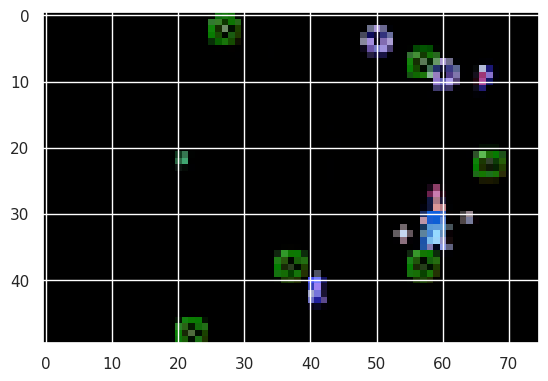



****************************************
Example no: 356
predicted:                    real
---H-H-----H-H-        ----H--------H-
MMMMMMMMMMMMMMM        MMMMMMMMMMMMMMM
---------------        ---------------
---------------        ---------------
---#TTTT-------        -----TT--------
---------------        ---------------
-H-HH------H-H-        ---H-----H-----
MMMMMMMMMMMMMMM        MMMMMMMMMMMMMMM
---------------        ---------------
-----------H---        --H--------H---


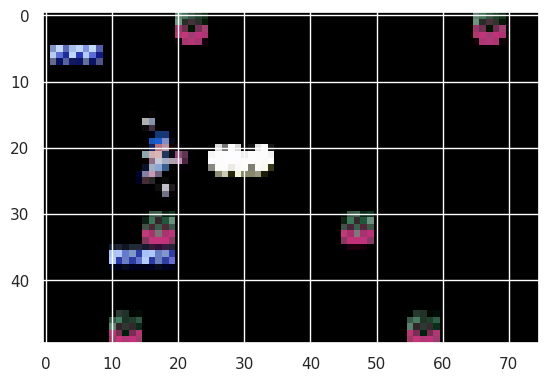



****************************************
Example no: 171
predicted:                    real
---------------        ---------------
---------------        ---------------
---------------        ---------------
---------------        ---------------
---------------        ---------------
---H----------H        ---H-----------
--DD----------D        --DD----------H
--DD---------DD        --DD---------DD
--DD----H-HH-DD        --DD---------DD
###############        ###############


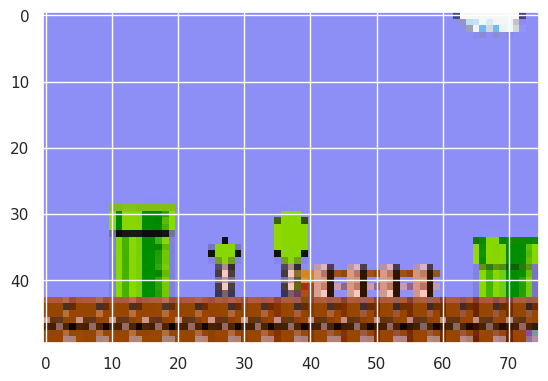



****************************************
Example no: 339
predicted:                    real
---------------        ---------------
--------SSSSSSS        ---------SSSSSS
---------------        ---------------
---------------        ---------------
---------------        ---------------
---------------        --------#----S-
---------------        --------#------
---------------        --------#------
------------HH-        --H-HH--#------
###############        ###############


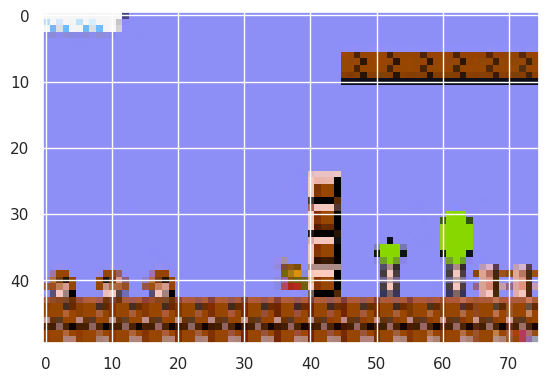



****************************************
Example no: 147
predicted:                    real
##-------------        ##------------#
#-------------#        ####--------###
###------------        ######------###
####----------D        ####--------###
####----------#        ####--------###
##-TTT-TTTTTTT#        ##----TTTTTTTT#
#D-------------        ##------------#
#D#-----------#        ##------------#
##TTTTT--------        #TTTT---H-----#
-#-------------        #MMMMMMMMMMMMMM


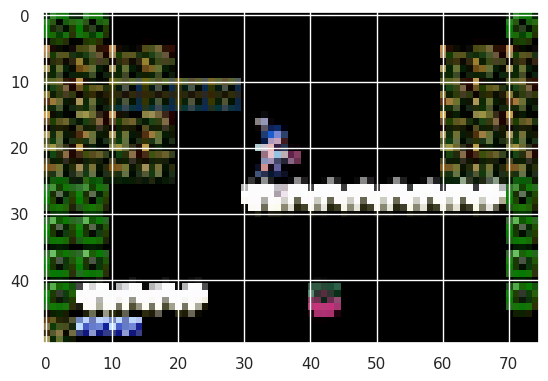



****************************************
Example no: 47
predicted:                    real
--#--H-----H-#-        ---------------
####MMMMMMMMMMM        ####--------###
---------------        ---------------
---------------        ---------------
-----TT--------        -----TTTT------
---------------        ---------------
--------------#        ####--------###
---------------        ------------###
---------------        -----------####
---------------        -------########


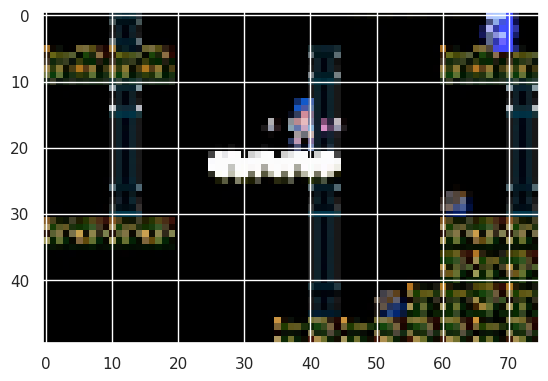



****************************************
Example no: 18
predicted:                    real
---------------        ---OO----------
---------------        ---------------
---------------        ---------------
---------------        ---------------
---------------        ---------------
---------------        ---------------
---------DH----        ----------H----
---------DD----        ---------DD----
-HHH-HH-DDD--#H        -H-HH----DD-H--
###############        ###############


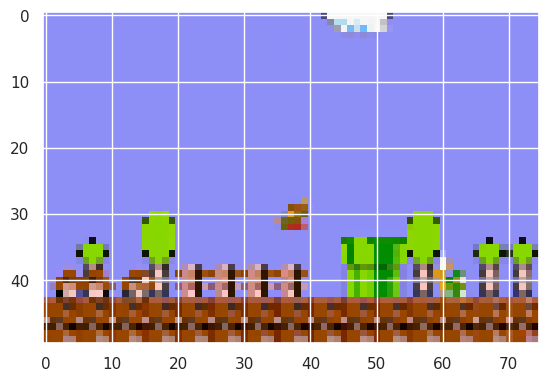



****************************************
Example no: 248
predicted:                    real
---------------        ---------------
-----BSSS------        -----OSS-------
---------------        ---------------
---------------        ---------------
---------------        ---------------
----O----------        ---------------
---------------        --H---H--------
---------------        ------H-------H
--H------------        ------H-------H
###############        ###############


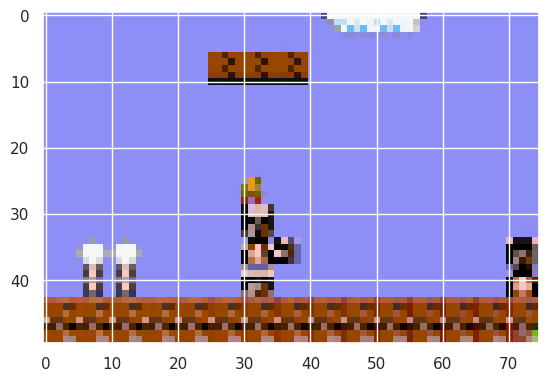



****************************************
Example no: 268
predicted:                    real
---------------        ---------------
----###TT------        ------TTT------
---D##D---TT#--        ---####--TTT---
---D###----###-        ---####---####-
-TTT###---####-        -TTT###---####-
----###---####-        ---#####--####-
----####--####-        ----####--####-
----####--####-        ----####--####-
----####TTTTTTT        ----####-TTTTTT
----####--###--        ----####--####-


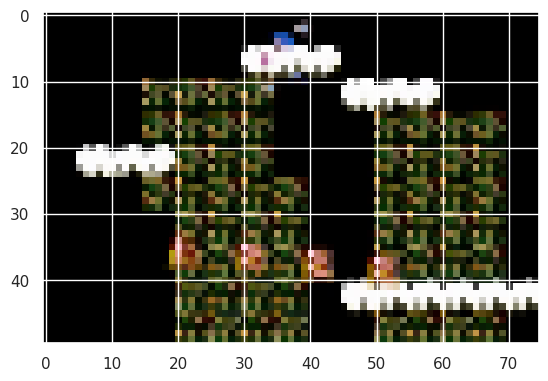



****************************************
Example no: 21
predicted:                    real
---------------        ---------------
---------------        ---------------
---------------        ---------------
---------------        ---------------
--------H------        --------H--S---
-------DD-----D        -------DD-----H
-------DD----DD        -------DD----DD
-------DD----DD        -------DD----DD
HHH----DD----DD        HH-H---DD----DD
###############        ###############


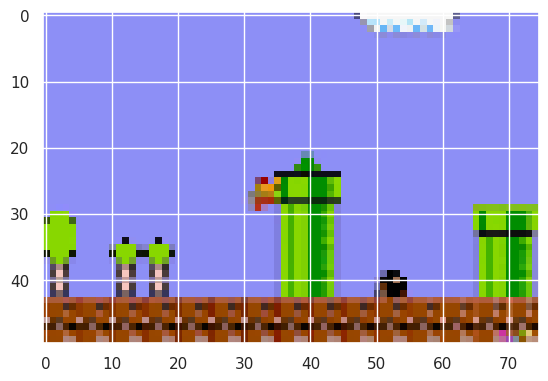



****************************************


In [ ]:
y_valid_pred_numerical = (np.argmax(y_valid_pred, axis = 3) + 1).astype('int')

for i in python_random.sample(range(len(y_valid)), 10):
  print("Example no:", i)
  print("predicted:" + " " * 20 + "real")

  decoded_pred = list(np.vectorize(reversed_enc_map.get)(y_valid_pred_numerical))[i]
  decoded_test = list(np.vectorize(reversed_enc_map.get)(y_valid_numerical))[i]


  for idx, row in enumerate(decoded_pred):
    print("".join(row) + "        " + "".join(decoded_test[idx]))

  plt.imshow(X_valid[i])
  plt.show()
  print("\n")
  print("****************************************")

In [ ]:
def plot_confusion_matrix(y_pred, y_true_numerical, title):
  letters = list(enc_map.keys())
  y_pred_numerical = (np.argmax(y_pred, axis = 3) + 1).astype('int')

  y_pred_string = np.vectorize(reversed_enc_map.get)(y_pred_numerical)
  y_true_string = np.vectorize(reversed_enc_map.get)(y_true_numerical)

  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cf_matrix = pd.DataFrame(
        confusion_matrix(y_true_string.flatten(),
        y_pred_string.flatten(), labels=letters),
        index=['{:}'.format(x) for x in letters],
        columns=['{:}'.format(x) for x in letters]
    )

    print(classification_report(
        y_true_string.flatten(),
        y_pred_string.flatten(),
        labels=letters)
    )

    from matplotlib.pyplot import figure
    figure(figsize=(10, 6), dpi=80)
    ax = sns.heatmap(cf_matrix, annot=True,cmap='BuPu', fmt='g', xticklabels=True, yticklabels=True)

    ax.set_title(title)
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')

    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [ ]:
import warnings

def per_game_stats(y_pred, y_numerical, frame_names):
  game_based_true = {game_key:[] for game_key in game_keys}
  game_based_pred = {game_key:[] for game_key in game_keys}

  for index, image_name in enumerate(frame_names):
    game_part = image_name.split("-")[0]
    game_based_true[game_part].append(y_numerical[index])
    game_based_pred[game_part].append(y_pred[index])

  for game in list(game_based_true.keys()):
      print(f"\n Displaying Game-specific stats for ***{game.upper()}***")
      plot_confusion_matrix(
          game_based_pred[game], game_based_true[game],
          title=f"Statistics of {game}"
      )


 Displaying Game-specific stats for ***KID_ICARUS***
              precision    recall  f1-score   support

           #       0.92      0.90      0.91     59418
           -       0.97      0.96      0.97    218159
           D       0.79      0.91      0.84      1170
           H       0.63      0.87      0.73      1732
           M       0.89      1.00      0.94      5283
           T       0.75      0.94      0.84     10938
           B       0.00      0.00      0.00         0
           S       0.00      0.00      0.00         0
           O       0.00      0.00      0.00         0

    accuracy                           0.95    296700
   macro avg       0.55      0.62      0.58    296700
weighted avg       0.95      0.95      0.95    296700



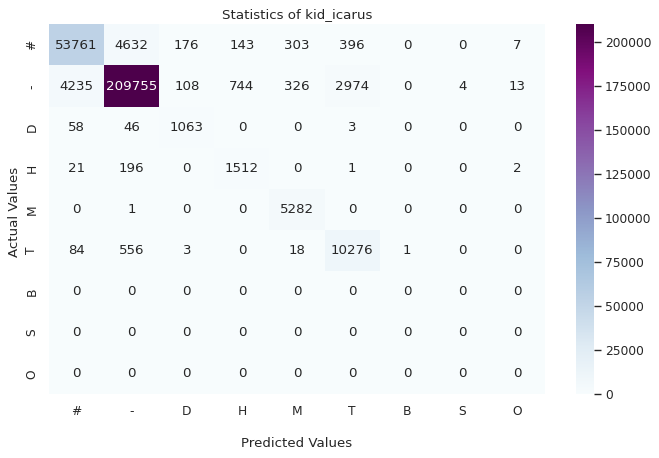


 Displaying Game-specific stats for ***SMB***
              precision    recall  f1-score   support

           #       0.89      0.92      0.90     37103
           -       0.98      0.95      0.96    237966
           D       0.94      0.98      0.96      6293
           H       0.48      0.57      0.52      3051
           M       0.00      0.00      0.00         0
           T       0.00      0.00      0.00         0
           B       0.49      0.94      0.64      1702
           S       0.73      0.90      0.80      8244
           O       0.49      0.84      0.61      2341

   micro avg       0.94      0.94      0.94    296700
   macro avg       0.55      0.68      0.60    296700
weighted avg       0.95      0.94      0.94    296700



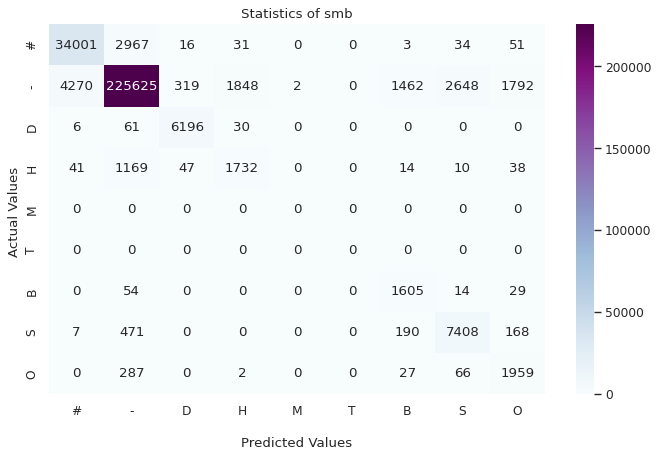

In [ ]:
# Evaluate Training Performance
per_game_stats(y_pred_train, y_train_numerical, X_train_frame_names)


 Displaying Game-specific stats for ***KID_ICARUS***
              precision    recall  f1-score   support

           #       0.67      0.47      0.55      2897
           -       0.87      0.92      0.89     18878
           D       0.05      0.06      0.06        47
           H       0.16      0.12      0.14       197
           M       0.59      0.57      0.58      1511
           T       0.47      0.48      0.47      1520
           B       0.00      0.00      0.00         0
           S       0.00      0.00      0.00         0
           O       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81     25050
   macro avg       0.31      0.29      0.30     25050
weighted avg       0.80      0.81      0.80     25050



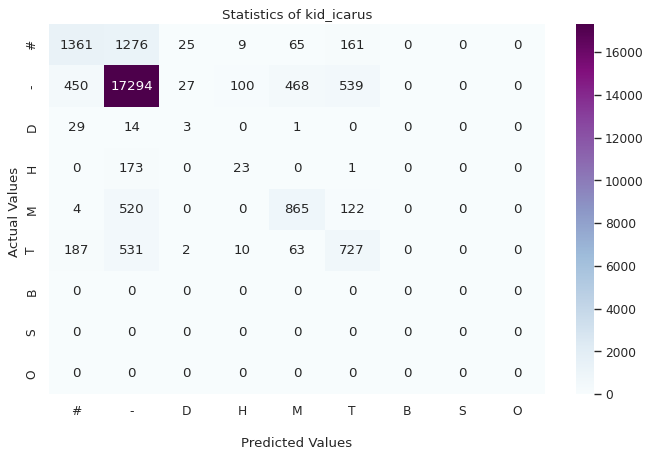


 Displaying Game-specific stats for ***SMB***
              precision    recall  f1-score   support

           #       0.89      0.91      0.90      3886
           -       0.96      0.96      0.96     23410
           D       0.90      0.95      0.93       575
           H       0.24      0.24      0.24       491
           M       0.00      0.00      0.00         0
           T       0.00      0.00      0.00         0
           B       0.14      0.93      0.25        28
           S       0.74      0.52      0.61       501
           O       0.00      0.00      0.00        59

   micro avg       0.93      0.93      0.93     28950
   macro avg       0.43      0.50      0.43     28950
weighted avg       0.93      0.93      0.93     28950



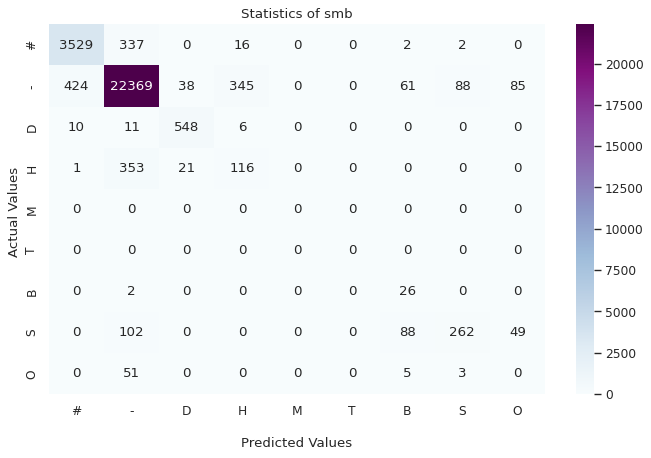

In [ ]:
# Evaluate Validation Performance
per_game_stats(y_valid_pred, y_valid_numerical, X_valid_frame_names)

In [ ]:
colors = []
for i in range(len(X_train_frame_names)):
  if "smb" in X_train_frame_names[i]:
    colors.append(0)
  else:
    colors.append(1)

In [ ]:
from sklearn.manifold import TSNE
encoded_inputs, _, _ = model.encoder(X_train)

# perform t-SNE embedding
vis_data = TSNE(learning_rate='auto', init='random', perplexity=100).fit_transform(encoded_inputs)
# vis_data = bh_sne(encoded_inputs.astype('float64'))
# plot the result
vis_x = vis_data[:, 0]
vis_y = vis_data[:, 1]

plt.scatter(vis_x, vis_y, c = colors, cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

In [ ]:
colors = []
for i in range(len(X_valid_frame_names)):
  if "smb" in X_valid_frame_names[i]:
    colors.append(0)
  else:
    colors.append(1)

In [ ]:
encoded_inputs, _, _ = model.encoder(X_valid)

# perform t-SNE embedding
vis_data = TSNE(learning_rate='auto', init='random', perplexity=100).fit_transform(encoded_inputs)
# vis_data = bh_sne(encoded_inputs.astype('float64'))
# plot the result
vis_x = vis_data[:, 0]
vis_y = vis_data[:, 1]

plt.scatter(vis_x, vis_y, c=colors, cmap=plt.cm.get_cmap("jet", 2))
plt.colorbar(ticks=range(2))
plt.clim(0, 1)
plt.show()